### Ejercicio 1 Hoja 4.
// Nos da un codigo y hay preguntas.
#include <stdio.h>
#include <unistd.h>
int num = 22; // Va a .data
int mul; // Va a .bss
ç

const char *msg = "El resultado es:\n"; // Va a .rodata


int main(void) 
{
    static int factor = 2; // Va a .data


    mul = num * factor; // Va a .text
    printf("%s%i\n", msg, mul); // Va a .text y a .rodata el formato


    sleep(600); // Va a .text. Lo pone a sleep para que podamos ver cosas de este proceso, 10 min para us. Y se le ha acabado


    return 0; // Va a .text
}
// Con {readelf programa} se lee un .elf y con -l se ven los segmentos.
// Te dice donde esta cada segmento con su offset en hexadecimal, el tamaño, los permisos (por ejemplo .txt es de solo // lectura y ejecutable; .rodata es de solo lectura y no ejecutable). Hay una tabla para rellenar con los datos sacados de // este comando.
// Podemos ver las cosas que hemos visto de la memoria de un procesos podemos ir al directorio del proceso. Viendo maps para // ver las listas de paginas y map_files. Tambien esta pagemap para ver las traducciones para ver en que marco de MF esta // pero esta en binario y yo no se tu pero no se leer binario.
// En map_files por columnas: direccion virtual-permisos-offset(desplazamiento desde el principio, raras por seguridad)-// // dispositivo(manor-minor?)(por si hubiese que recuperar cosas)-inodo-path(que lo respalda). Si no hay path son anonimas, // // solo estan en memoria, si se pierden se pierden. Se ven las librerias compartidas tambien, eh heap y el stack y se ve que
// el stack crece hacia arriba porque la diferencia de direcciones es grande y lo mismo con el heap.
// En maps, regiones de memoria. Mirando desde maps y metiendonos en este directorio y usando... Se le ha acabado el tiempo, // como no hemso recompilado el programa el offset no ha cambiado pero las paginas virtuales son distintas... {sudo strings // (de la ruta donde sabemos que esta por ejemplo .rodata)} podemos ver "El resultado es:\n" y "%s%i\n" entre otras cosas que // tiene .rodata. Si pones al {strings} el .elf pues te muestra todo y entre todo el batiburrillo y en la posicion a partir
// del offset pues efectivamente te vuelves a encontrar las cosas de .rodata.

### Ejercicio 7:
Da: 

In [ ]:

#include <stdio.h>
#include <unistd.h>
#include <stdlib.h>

int main(int argc, char *argv[]) {
    int factor    = atoi(argv[1]);
    int elementos = factor * 1024;
    printf("Inicializando región de memoria\n");
    int * ptr = (int *) malloc(elementos * sizeof(int));
    for (size_t i = 0; i < elementos; i++){
        ptr[i] = 1;
    }
    sleep(600);
    return 0;
}


Responde:

Realiza dos ejecuciones con el comando strace para identificar cómo se reserva la memoria del array ptr. Consulta el mapa de memoria del proceso en /proc para completar la siguiente tabla para la región de memoria dónde está la memoria del array. Nota: lee la sección NOTES de la página de manual de malloc(3).

Caso A. strace ./ejercicio7 1
Caso B. strace ./ejercicio7 1024

Malloc al pedir

### Ejercicio 3
Escribe un programa que cree una región de memoria (mmap(2)) con las siguientes
características:

- Tamaño 1024 bytes
- Acceso privado
- Modo lectura y escritura

Una vez creada la región de memoria el proceso la inicializará con ‘\0’ (usar un bucle o la llamada
memset(3)), mostrará la dirección del segmento (modificador de formato %p) y el PID del proceso.
Finalmente el proceso hará un sleep de 600s. Ejemplo de ejecución:

In [ ]:
// MiMAlloc.c

#include <stdio.h>
#include <unistd.h>
#include <stdlib.h>

int main(int argc, char *argv[]) {
    // Malloc hace la reserva de memoria en el momento de la llamada
    void * ptr = mmap(NULL,                         // Dirección de memoria (NULL para que el SO asigne)
                        1024,                       // 1kB de memoria
                        PROTO_READ | PROTO_WRITE,   // Permisos de lectura y escritura
                        MAP_PRIVATE | MAP_ANON,     // Sin fichero asociado
                        -1,                         // Descriptor de fichero (no aplica)
                        0                           // Offset en el fichero (no aplica)
                    );
    
    // Comprobamos errores, MAP_FAILED es (void *) -1 mas info en man mmap
    if (ptr == MAP_FAILED) {
        perror("Error en creacion de mmap");
        return 1;
    }
    
    // Inicializamos la memoria a 0
    memset(ptr, 0, 1024); 
    // Mostramos el PID y la dirección de la VMA = memoria asignada
    printfI("PID: %i, VMA: %p\n", getpid(), ptr);
    // Esperamos para poder inspeccionar el proceso
    sleep(6000);

    return 0;
}

### Ejercico 4
Re-escribir el ejercicio 11 de la Hoja 3 proyectando el fichero de salida (output.txt)
en la memoria virtual:

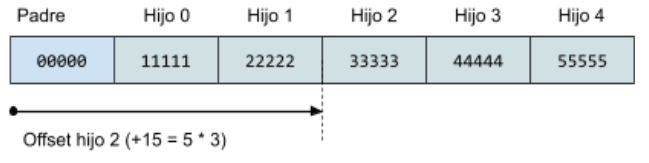

El esquema es el siguiente:
- Preparación del segmento de memoria. Cuando se proyecta un fichero debe tener al
menos el tamaño de la región que se quiere crear, y se debe abrir con el mismo modo que se
quiere crear la región (lectura, escritura,...). Las acciones que realizará el proceso padre son:
    - Crear el fichero de salida con la llamada open(2) y las opciones O_TRUNC y
lectura/escritura.
    - Para fijar el tamaño de la región usaremos la llamada al sistema ftruncate(2)
(fichero sparse)
    - Proyectará en la memoria virtual del proceso con (mmap(2)). Nota: convertir el puntero retornado por map() a char *
    - Cerrar el descriptor (close(2)), esto no afecta al segmento de memoria
proyectado
- Inicialización del segmento de memoria. Se crearán los hijos que usarán su identificador
como base del desplazamiento a la zona de memoria y fijará en cada posición el caracter
correspondiente. Truco: se puede usar el operador + en variables de tipo char para
movernos por la tabla de caracteres, por ejemplo: (char) ‘5’ = (char) ‘0’ + (int) 5
- Finalización. El proceso padre esperará la finalización de todos los hijos y eliminará la
región con las llamadas msync(2) y munmap(2).

In [ ]:
#include <stdio.h>
#include <unistd.h>
#include <stdlib.h>

// Función para escribir un carácter en la memoria compartida
void write_char(void * _ptr, int proc) {
    char* ptr = (char *) _ptr; // Cast a char*

    // Comprobar que esto este bien.
    // Forma con memset (menos eficiente).
/*
*   memset(&ptr[proc*5], '0' + proc, 5); // Escribimos 5 caracteres correspondientes al número de proceso
*/


    // Forma iterativa.
    for (int i = 0; i < 5; j++){
        ptr[(proc*5) + i] // Se multiplica por 5 por que cada proceso escribe 5 caracteres, ocupa 5 posiciones del array en memoria.
            = '0' + proc; // Escribimos el carácter correspondiente al número de proceso
    }
}


int main(int argc, char *argv[]) {
    // Preparacion de la region de memoria
    //      1. abrir un fichero (backing store) (Porque quiero que la memoria persista despues de que el proceso termine)
    //      2. tamaño del fichero = 30 bytes (Porque voy a almacenar 30 caracteres)
    //      3. Mapa compartido (Porque voy a tener varios procesos accediendo a la misma zona de memoria)
    //      4. Mapa con permisos de lectura/escritura (Porque voy a leer y escribir en la memoria)

    // (1) Abrir el fichero
    int fd = open("salida.txt",             // Nombre del fichero
                O_RDWR | O_TRUNC | O_CREAT, // Abrir para lectura y escritura, truncar si existe, crear si no existe
                0660                        // Permisos rw-rw---- (usuario y grupo pueden leer y escribir, ninguo para otro)
            );

    // Comprobar errores
    if (fd == -1) {
        perror("Error al abrir/crear el fichero");
        return 1;
    }

    // (2) Ajustar el tamaño del fichero
    int tam = 30; // tamaño en bytes, 30 bytes para almacenar 30 caracteres
    if (ftruncate(fd, tam) == -1) { // if para comprobar errores
        perror("Error al ajustar el tamaño del fichero");
        close(fd);
        return 1;
    }

    // (3) Crear el mapeo de memoria
    void * ptr = mmap(NULL,                         // Dirección de memoria (NULL para que el SO asigne)
                        tam,                        // Cantidad de memoria
                        PROTO_READ | PROTO_WRITE,   // Permisos de lectura y escritura
                        MAP_PRIVATE | MAP_ANON,     // Sin fichero asociado
                        -1,                         // Descriptor de fichero (no aplica)
                        0                           // Offset en el fichero (no aplica)
                    );
                    
    // Comprobamos errores, MAP_FAILED es (void *) -1 mas info en man mmap
    if (ptr == MAP_FAILED) {
        perror("Error en creacion de mmap");
        return 1;
    }
    
    // Padre escribe en la memoria.
    write_char(ptr, 0); // Proceso 0 escribe en la memoria                
    
    // Crear 5 procesos hijos
    for (int i = 1; i < 6; i++) {
        pid_t pid = fork();

        // Proceso hijo
        if (pid != 0) {
            continue; // El padre sigue creando hijos
        } 

        // Proceso hijo escribe en la memoria
        write_char(ptr, i); // Proceso i escribe en la memoria
        // Opciones para que el proceso hijo no termine inmediatamente
        // break; // Sale del bucle y termina el proceso hijo, pero como no tiene nada mas que hacer, termina inmediatamente cpn exit(0)
        exit(0);  // Termina el proceso hijo
    }

    // Padre espera a que terminen los hijos
    for (int i = 1; i < 5; i++) {
        int status;
        pid_t pid = wait(&status); // Espera a que un hijo termine

        printf("HIJO %i terminado con estado %i\n", pid, status);
    }

    // Sincronizar la memoria mapeada con el fichero
    if (msync(ptr, tam, MS_SYNC) == -1) { // Se comprueba errores
        perror("Error al sincronizar la memoria con el fichero");
        return 1;
    }
    
    close(fd); // Cerrar el fichero
    unmap(ptr, tam); // Desmapeamos la memoria

    return 0;
}

### Ejercicio 6
Considera un sistema operativo con una memoria virtual paginada de un nivel y tamaño de página de 512 palabras. El espacio de direcciones virtuales tiene 512 páginas y la memoria física tiene 10 marcos de página.
- Describe la estructura del espacio de direcciones virtuales y física, y de la tabla de páginas que usaría el sistema operativo. Indica el tamaño de todos los campos.
- Si el contenido de la memoria física es el que se muestra a continuación, determina el contenido de la tabla de páginas del proceso. ¿Qué dirección física corresponde con las direcciones virtuales 0x13FF y 0x1403?
- ¿Qué ocurre si un proceso intenta acceder a la posición 0x80E8?
- Supongamos que el marco de página en las direcciones 0x0800-0x09ff se quiere compartir con otro proceso. ¿Debería asignarse al mismo segmento virtual? 

### Ejercicio 8
 Un sistema tiene un uso medio de la CPU del 15% (usuario) y 3% (sistema), el área de swap está ocupada al 92%. La salida del comando ps muestra 50 procesos en estado “D” (espera no interrumpible) . ¿Cuál de estas acciones aumentará más la utilización de la CPU?:
- Ampliar la memoria principal
- Ejecutar más programas para aumentar el grado de multiprogramación 
- Aumentar el área de swap
- Añadir más CPU’s


### Ejercicio 9
 En un sistema con memoria virtual paginada indicar las acciones son realizadas por el sistema operativo (especificando a qué estructuras de datos accede y como las modifica) en los siguiente casos: 
- un proceso intenta escribir en una página de solo lectura
- un proceso intenta acceder a una dirección correspondiente a una página que no está en memoria.
